# importing libraries

In [ ]:
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Conv2DTranspose, Reshape
from keras.utils import plot_model
import numpy as np
import os

# Loading data

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = load_data()

# Reshape dataset
x_train = np.expand_dims(x_train, axis=-1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1,1]

In [ ]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


# Showing Some Images

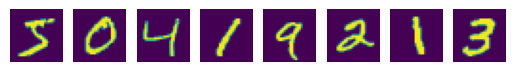

In [ ]:
for i in range(8):
  plt.subplot(1,8,1+i)
  plt.imshow(x_train[i])
  plt.axis('off')

plt.show()

#Defining Discriminator

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()

    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))  # we not applyed the Maxpolling because the "stride" give the bater result as compared to Maxpolling

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))          # if the prediction is near to "0" it means the image is fack
                                                       # if the prediction is near to "1" it means the image is real
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_84 (LeakyReLU)           │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_85 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_86 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_87 (LeakyReLU)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521,345 (1.99 MB)

 Trainable params: 521,345 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

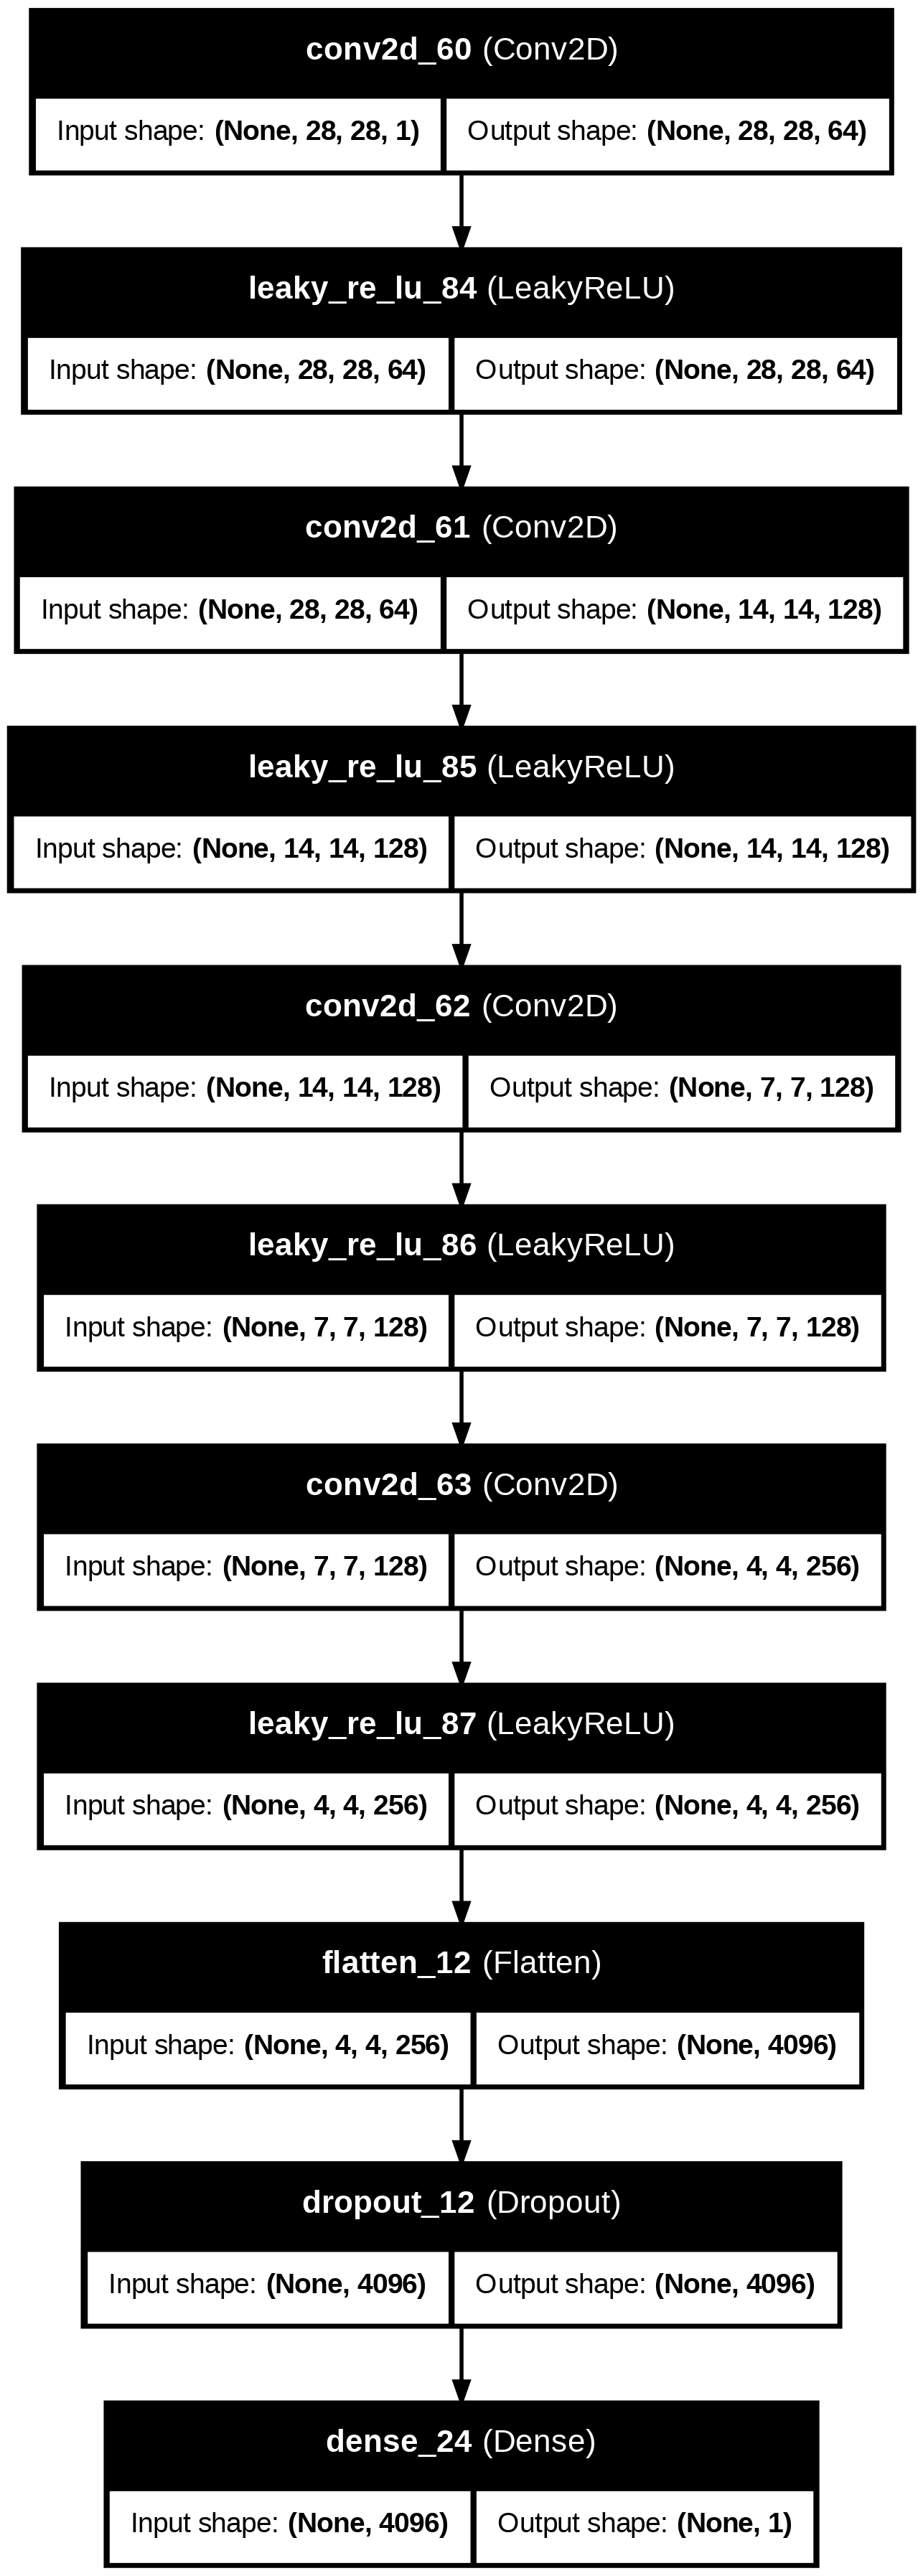

In [ ]:
model=define_discriminator()
model.summary()
plot_model(model,to_file='discriminator_plot.png',show_shapes=True,show_layer_names=True)

## Seeing How the Discriminator work
### we know to train the discriminator we need the real and the fack both data so first make the real data and than make the fake data

### making real data

In [ ]:
def load_real_sample():
  (x_train,_),(_,_)=load_data()    #we just need the real x_train as real so just load it ....
  x=x_train.astype('float32')      # it is recommanded to avoid from the compatebility issue at any level of traing
  x=(x-127.5)/127.5                # As we use the Tanh() as activation function a head so its good to make the pixcel values between the [-1,1]
  return x                         #so scale it 127.5 instead of 256 it is also proven by experiments


In [ ]:
X=load_real_sample()
print(X.shape)

(60000, 28, 28)


In [ ]:
def generated_real_sample(dataset, n_samples):
  ''' as we not give the 60000 image directly to the discriminator so we give the image in the batch form 64 real and 64 fack so
  first get the real 64 image batch and mark tham as the real by puting the "1" in the traget colom "y"
  '''
  ix=np.random.randint(0, dataset.shape[0], n_samples)
  x=dataset[ix]
  x = np.expand_dims(x, axis=-1)
  y=np.ones((n_samples, 1))
  return x,y

real_x,real_y = generated_real_sample(X,64)
print(real_x.shape)
print(real_y.shape)

(64, 28, 28, 1)
(64, 1)


### making the fake data

(64, 28, 28, 1)
(64, 1)


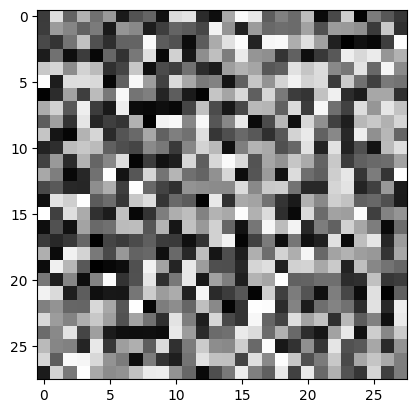

In [ ]:
import numpy as np

def generated_fake_sample(n_samples):
    '''You just mention how many images you need, and the function
    gives you fake images and marks them as fake by putting "0" in the target column "y".'''

    x = np.random.rand(n_samples , 28 , 28 , 1 )  # Corrected shape
    x = -1 + x * 2
    x = x.reshape((n_samples, 28, 28, 1))
    y = np.zeros((n_samples, 1))

    return x, y

# Generating 64 fake samples
fake_x, fake_y = generated_fake_sample(64)

print(fake_x.shape)
print(fake_y.shape)
plt.imshow(fake_x[0], cmap='gray')
plt.show()

### Train the discriminator

In [ ]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  '''
  total 128(real and fake)image goes in one pass but its is prefer that we send the images in the 64(real) + 64(fake) seperatly
  and update the weights in backpropergation after each 64 images  ....
  and  as  n_iter=20 so we can update the wight total 40 time(2 time in each iteration) so this is done by the "train_on_batch" function
  '''
  half_batch=int(n_batch/2)  # so we divide the batch

  for i in range(n_iter):

    x_real,y_real=generated_real_sample(dataset,half_batch)
    _,real_acc=model.train_on_batch(x_real,y_real)

    x_fake,y_fake=generated_fake_sample(half_batch)
    _, fake_acc=model.train_on_batch(x_fake, y_fake)

    print(">%d real=%.0f%% fake=%0.f%%"% (i+1, real_acc*100, fake_acc*100))

model=define_discriminator()
dataset = load_real_sample()
train_discriminator(model,dataset)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


>1 real=77% fake=39%
>2 real=59% fake=45%
>3 real=56% fake=47%
>4 real=55% fake=50%
>5 real=56% fake=58%
>6 real=62% fake=65%
>7 real=68% fake=70%
>8 real=72% fake=74%
>9 real=75% fake=77%
>10 real=78% fake=79%
>11 real=80% fake=81%
>12 real=82% fake=83%
>13 real=83% fake=84%
>14 real=84% fake=85%
>15 real=86% fake=86%
>16 real=86% fake=87%
>17 real=87% fake=88%
>18 real=88% fake=88%
>19 real=89% fake=89%
>20 real=89% fake=90%


# Defining Generator Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_92 (LeakyReLU)           │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_12 (Reshape)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_24                  │ (None, 14, 14, 128)         │         524,416 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_93 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_25                  │ (None, 28, 28, 128)         │         262,272 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_94 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 28, 28, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,054,785 (7.84 MB)

 Trainable params: 2,054,785 (7.84 MB)

 Non-trainable params: 0 (0.00 B)

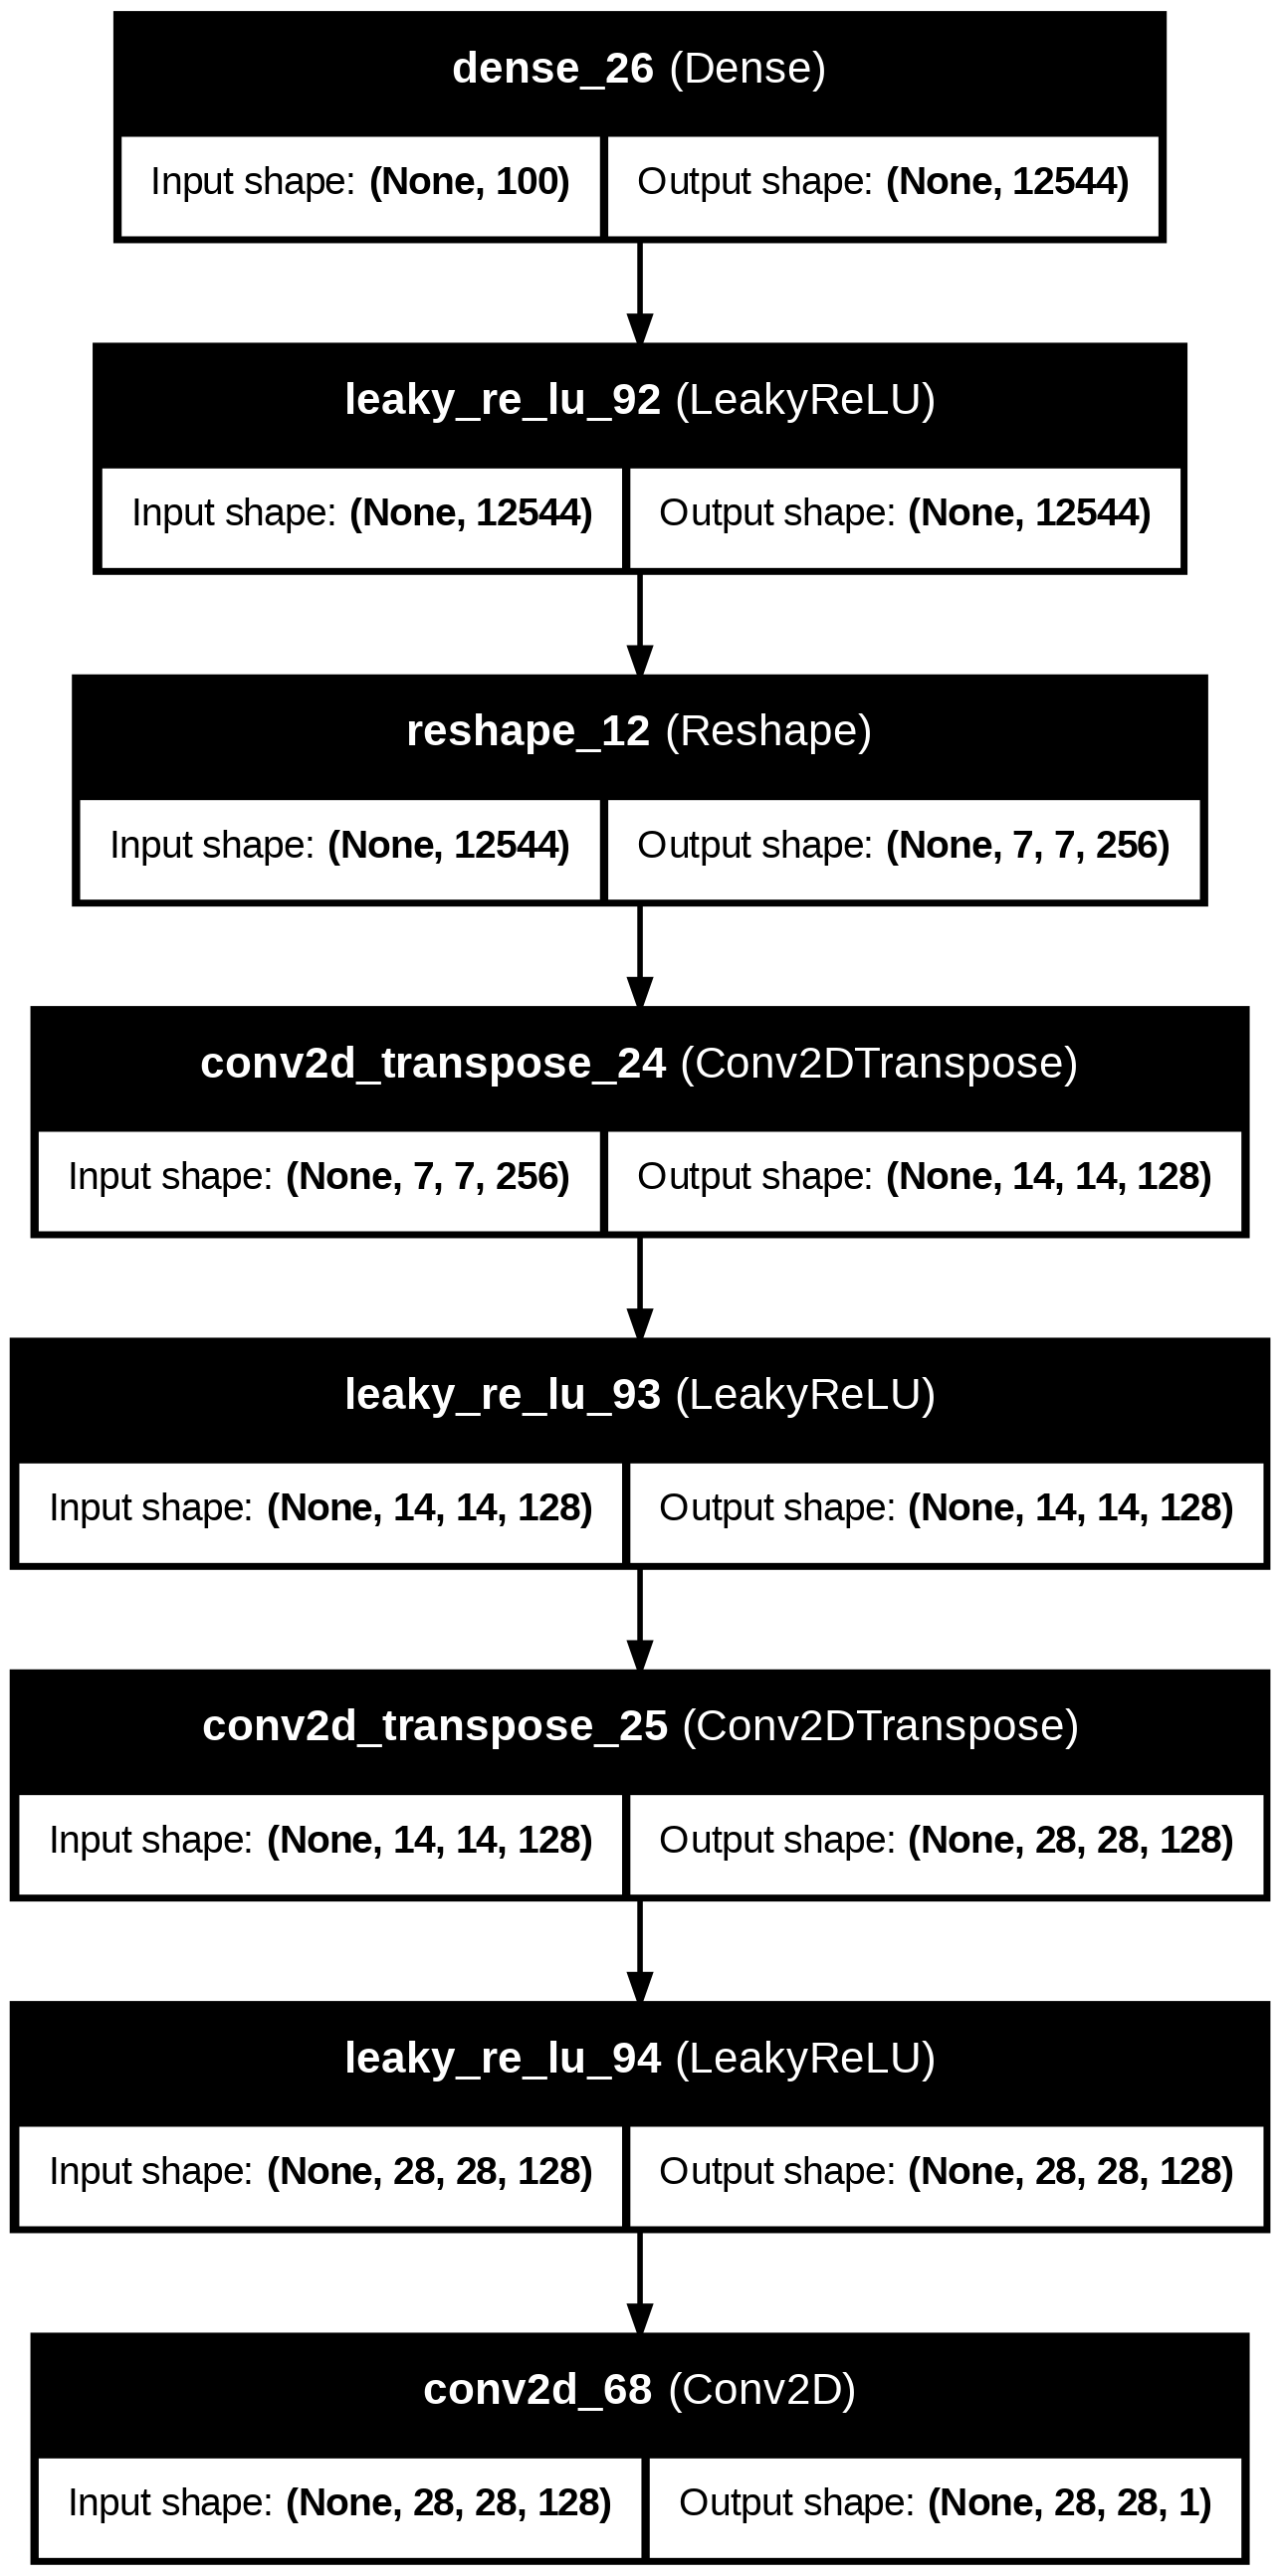

In [ ]:
def define_generator(latent_dim):
  ''' this take the 1-D vector (could contain the 50, 40 0r 100 ramdom values)  for generating the (28x28)one chanel one image.
  '''
  model = Sequential()
  ''' it is recommanded that the if you want the generated image in the 32x32 so should chose the number of input node in the input layer
  that equal to the product of 32x32 or 16x16 or 4x4 So, for our case we need the 28X28 image so we select either 28X28 or 14x14 or 7x7....
  therefore we take the 256 images of 7x7 which after the next 4 lines of code
  '''
  n_nodes = 7 * 7 *  256
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 256)))
  # increase-size/upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # increase-size/upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
  return model

generator_model=define_generator(latent_dim=100)
generator_model.summary()
plot_model(generator_model,to_file='generator_plot.png',show_shapes=True,show_layer_names=True)

## Now create function that create the latent point for  number of  images as many want

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  ''' the function give use to generate the samples that are the given to the generator model to make the images than those generated image give the
  discriminator model with the real images to train the discriminator model.
  '''
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

x_input=generate_latent_points(100,64)
print(x_input.shape)
print(x_input[0])
print(len(x_input[0]))

(64, 100)
[-2.4208062   0.017506    0.31706896 -0.69620815  2.52218094 -0.38781797
  0.2455791  -0.35002894 -0.20856591  1.17184256 -0.88335833  0.73470406
  1.35793323 -0.05622547  2.6491363  -0.56567462  0.14967391  0.43339758
  0.15139403  0.19560366 -0.13733861 -1.16795002 -0.39891261 -1.43142199
  1.09683574 -0.61381363 -0.61796815  1.52174009 -0.01670882  0.45319278
 -0.28777185  1.7657964  -1.08840934  2.06763453 -0.16018976  0.36311428
 -1.18843593 -1.87545296  0.86549071 -0.27821136 -0.77473458 -0.57602795
 -0.36884636  1.05693651 -0.68681339 -2.11391532 -0.2777835   1.56153963
 -1.68451305 -0.7289314   0.16191348  0.629136   -1.78277724  0.15282798
  1.09546046  1.29206658 -0.56074627 -0.84993898  0.202395   -0.04957202
 -1.10556108 -0.21329293 -1.58842943 -1.27928941 -0.42320607  1.03019414
 -0.68284303 -1.46543181  0.66115495 -0.434355    0.06071071 -1.76070426
  0.95583937  0.3767473   0.77743005  0.59123948 -0.94093333  0.12337638
 -1.27953119  0.74271941  0.84857137 -0.7

## making the fake sample for generator

In [ ]:
def generate_fake_samples(generator_model, latent_dim, n_samples):
  '''
  This fuction return the fake sample geneted by the generator model and mark then as
  the fake and put the "0" in the column "y"
  '''
  x_input = generate_latent_points(latent_dim, n_samples)
  x = generator_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return x, y

## Showing generated fake sample from the generator

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


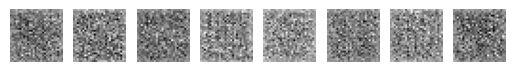

In [ ]:
latent_dim = 100
generator_model = define_generator(latent_dim)
n_samples = 8
x,_ = generate_fake_samples(generator_model, latent_dim, n_samples)
x=(x+1)/2.0

for i in range(8):
  plt.subplot(1,8,1+i)
  plt.imshow(x[i],cmap='gray')
  plt.axis('off')

plt.show()

## making the real sample for the discriminator

In [ ]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    x = dataset[ix]
    x = np.expand_dims(x, axis=-1)     #changes occurs
    y = np.ones((n_samples, 1))
    return x, y

# GAN Model

In [ ]:
def define_gan(generator_model, discriminator_model):
  '''in composite model of generetor and discriminator we just train the generator part only because we want to
  minimize the loss of output of composite model..because we just already give the fake image as the real to the discriminator model '''
  discriminator_model.trainable = False

  model = Sequential()
  model.add(generator_model)
  model.add(discriminator_model)

  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_32 (Sequential)           │ (None, 28, 28, 1)           │       2,054,785 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_33 (Sequential)           │ (None, 1)                   │         521,345 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,576,130 (9.83 MB)

 Trainable params: 2,054,785 (7.84 MB)

 Non-trainable params: 521,345 (1.99 MB)

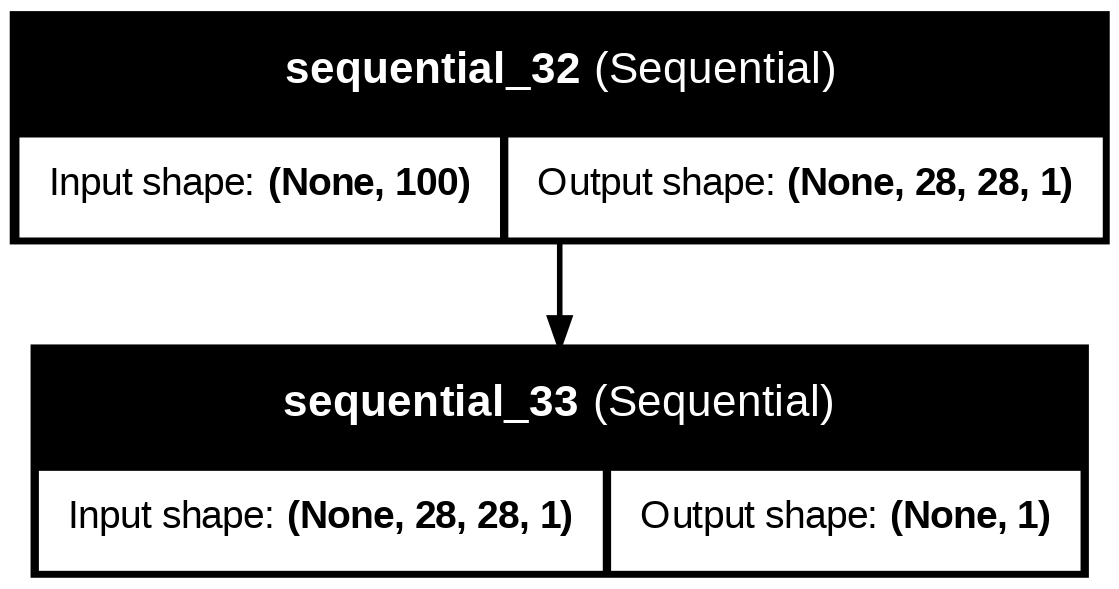

In [ ]:
latent_dim=100

generator_model=define_generator(latent_dim)
discriminator_model=define_discriminator()


gan_model=define_gan(generator_model,discriminator_model)
gan_model.summary()
plot_model(gan_model,to_file='gan_plot.png',show_shapes=True,show_layer_names=True)

## Traing Loop

In [ ]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=128):
  bat_per_epo=int(dataset.shape[0]/n_batch)    # 60000/128=468.75
  half_batch=int(n_batch/2)

  for i in range(n_epochs):
    for j in range(bat_per_epo):
      '''total the code run in the 100 epoch and in every epoch the 468 batch run and in one run of one batch total 128 images pass , 64 real and 64 fake.
        In next four line of code first the discriminator model train with first 64 real and secondly 64 fake images
      '''
      x_real,y_real = generate_real_samples(dataset,half_batch)
      d_loss1,_ = d_model.train_on_batch(x_real,y_real)     # we skip the accuracy of the discriminator here and store loss

      x_fake,y_fake = generate_fake_samples(g_model, latent_dim,half_batch)
      d_loss2,_ = d_model.train_on_batch(x_fake,y_fake)

      '''
      Now train the gan_model whole and train the generator model so for this make the images and tell the generator those are ture...
      '''

      x_gan=generate_latent_points(latent_dim,n_batch)
      y_gan=np.ones((n_batch,1))

      g_loss=gan_model.train_on_batch(x_gan,y_gan)

      print("epoch:%d, batch:%d/%d, real_loss_of_discriminator:%.3f, fake_loss_of_discriminator:%.3f, loss_of_gan=%.3f"%(i+1,j+1, bat_per_epo,d_loss1,d_loss2, g_loss))

  if(i+1)==5 or 10:
    summarize_performance(i,g_model,d_model,dataset,latent_dim)

### performance measure

In [ ]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=150):

  x_real,y_real = generate_real_samples(dataset, n_samples)
  _,acc_real = d_model.evaluate(x_real,y_real,verbose=0)

  x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
  _,acc_fake = d_model.evaluate(x_fake,y_fake,verbose=0)

  print(">>>>Accuracy real:%.0f, fake: %.0f%%"% (acc_real*100,acc_fake*100))
  save_plot(x_fake,epoch)

  filename='generator_model_%03d.h5'%(epoch+1)
  g_model.save(filename)

### ploting so new generated images and saving

In [ ]:
def save_plot(examples, epoch,n=7):
  examples=(examples+1)/2.0
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.imshow(examples[i])
    plt.axis('off')

  plt.show()
  filename='generator_model_%03d.png'%(epoch+1)
  plt.savefig(filename)
  plt.close()

## calling training loop

In [ ]:
train(generator_model,discriminator_model,gan_model,dataset,latent_dim=100,n_epochs=10,n_batch=128)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
epoch:1, batch:111/468, real_loss_of_discriminator:0.742, fake_loss_of_discriminator:0.742, loss_of_gan=0.605
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
epoch:1, batch:112/468, real_loss_of_discriminator:0.742, fake_loss_of_discriminator:0.743, loss_of_gan=0.604
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
epoch:1, batch:113/468, real_loss_of_discriminator:0.742, fake_loss_of_discriminator:0.743, loss_of_gan=0.604
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
epoch:1, batch:114/468, real_loss_of_discriminator:0.743, fake_loss_of_discriminator:0.743, loss_of_gan=0.603
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
epoch:1, batch:115/468, real_loss_of_discriminator:0.743, fake_loss_of_discriminator:0.744, loss_of_gan=0.603
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
epoch:1, batch:116/468, real_loss_of_discriminator:0.744, fake_loss_of_discriminator:0.744, loss_of_gan=0.602
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
epoch:1, batch:117/468,

In [ ]:
# latent_dim = 100
# d_model = define_discriminator()
# g_model = define_generator(latent_dim)
# gan_model = define_gan(g_model, d_model)
# dataset = x_train
# train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128)